In [1]:
%matplotlib inline

In [2]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from lightkurve import TessLightCurveFile
from astropy.coordinates import SkyCoord
import astropy.units as u
import lightkurve

import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
import theano
from scipy.signal import savgol_filter

In [3]:
print(xo.__version__)
print(theano.__version__)
print(pm.__version__)

0.1.3
1.0.4
3.6


In [4]:
target = 'AU Mic'
lcf = lightkurve.search_lightcurvefile(target).download(quality_bitmask='hard',)
lc = lcf.get_lightcurve('PDCSAP_FLUX').normalize()

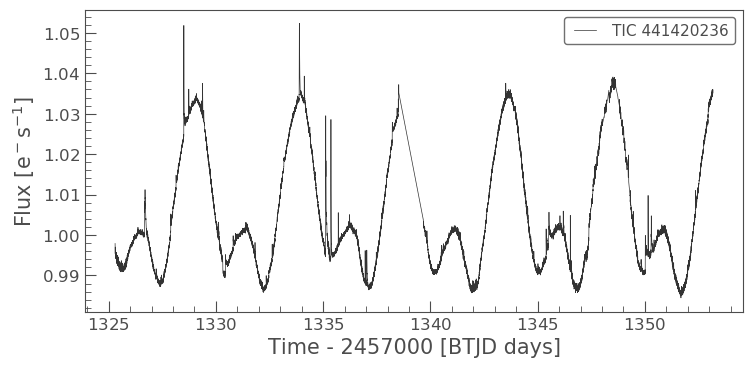

In [5]:
lc_hdr = lcf.header(ext=1)
lc.plot(normalize=False)

In [6]:
texp = lc_hdr["FRAMETIM"] * lc_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
ref_time = 0.5 * (lc.time.min() + lc.time.max())
flux = (lc.flux - 1.0) * 1e3
time = lc.time
flux_err = lc.flux_err
m = np.isfinite(time) & np.isfinite(flux)
time = time[m]
flux = flux[m]
flux_err = flux_err[m]

In [7]:
# Identify outliers
m = np.ones(len(flux), dtype=bool)
for i in range(20):
    y_prime = np.interp(time, time[m], flux[m])
    smooth = savgol_filter(y_prime, 301, polyorder=3)
    resid = flux - smooth
    sigma = np.sqrt(np.mean(resid**2))
    m0 = resid < sigma*0.5
    if m.sum() == m0.sum():
        m = m0
        break
    m = m0

/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


(1330, 1332)

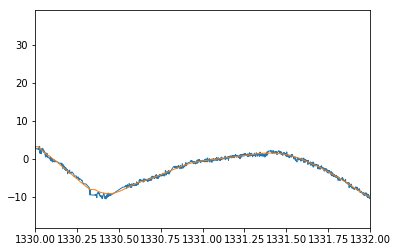

In [8]:
plt.plot(time[m], flux[m], lw=1)
plt.plot(time, smooth, lw=1)
plt.xlim(1330,1332)

In [9]:
time = np.ascontiguousarray(time[m] - ref_time, dtype=np.float64)
flux = np.ascontiguousarray(flux[m], dtype=np.float64)
flux_err = np.ascontiguousarray(flux_err[m], dtype=np.float64)

x = time
y = flux
yerr = flux_err

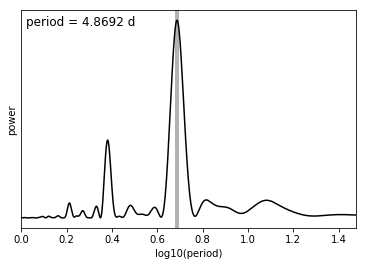

In [10]:
results = xo.estimators.lomb_scargle_estimator(
    x, y, max_peaks=1, min_period=1.0, max_period=30.0,
    samples_per_peak=50)

peak = results["peaks"][0]
ls_period = peak["period"]
freq, power = results["periodogram"]
plt.plot(-np.log10(freq), power, "k")
plt.axvline(np.log10(ls_period), color="k", lw=4, alpha=0.3)
plt.xlim((-np.log10(freq)).min(), (-np.log10(freq)).max())
plt.annotate("period = {0:.4f} d".format(ls_period),
             (0, 1), xycoords="axes fraction",
             xytext=(5, -5), textcoords="offset points",
             va="top", ha="left", fontsize=12)
plt.yticks([])
plt.xlabel("log10(period)")
plt.ylabel("power");

In [11]:
def build_model(mask=None, start=None):
    guess_p_period = 16.93, 30.537
    guess_p_t0 = -8.84, 2.9955
    guess_p_depth = 0.04, 0.02
    if mask is None:
        mask = np.ones_like(x, dtype=bool)
    with pm.Model() as model:

        # The mean flux of the time series
        mean = pm.Normal("mean", mu=6, sd=15.0)

        # A jitter term describing excess white noise
        logs2 = pm.Normal("logs2", mu=2*np.log(np.min(yerr[mask])), sd=5.0)

        # A SHO term to capture long term trends
        logS = pm.Normal("logS", mu=0.0, sd=15.0, testval=np.log(np.var(y[mask])))
        logw = pm.Normal("logw", mu=np.log(2*np.pi/10.0), sd=10.0)
        term1 = xo.gp.terms.SHOTerm(log_S0=logS, log_w0=logw, Q=1/np.sqrt(2))
        
        # The parameters of the RotationTerm kernel
        logamp = pm.Normal("logamp", mu=np.log(np.var(y[mask])), sd=5.0)
        logperiod = pm.Normal("logperiod", mu=np.log(ls_period), sd=0.2)
        period = pm.Deterministic("period", tt.exp(logperiod))
        logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
        logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
        mix = pm.Uniform("mix", lower=0, upper=1.0)
        term2 = xo.gp.terms.RotationTerm(
            log_amp=logamp,
            period=period,
            log_Q0=logQ0,
            log_deltaQ=logdeltaQ,
            mix=mix
        )

        u_star = xo.distributions.QuadLimbDark("u_star",
                                              testval=np.array([0.4, 0.2]))
        R_star = 0.75, 0.1
        Rho_star = 0.9
        r_star = pm.Normal("r_star", mu=R_star[0], sd=R_star[1])
        logrho_star = pm.Normal("logrho_star", mu=np.log(Rho_star), sd=0.4)
        rho_star = pm.Deterministic("rho_star", tt.exp(logrho_star))
        pm.Potential("r_star_prior", tt.switch(r_star > 0, 0, -np.inf))
        logP = pm.Normal("logP", mu=np.log(guess_p_period), sd=0.1, shape=2, 
                         testval=np.log(guess_p_period))
        t0 = pm.Normal("t0", mu=guess_p_t0, sd=0.1, shape=2, testval=guess_p_t0)
        
        logror = pm.Bound(pm.Normal, lower=np.log(0.0), upper=np.log(0.3))("logror", 
                                                                            mu=np.log(guess_p_depth),
                                                                            sd=2, shape=2)
        ror = pm.Deterministic("ror", tt.exp(logror))
        b_param = pm.Uniform("b_param", lower=0, upper=1, shape=2, testval=[0.2, 0.3])
        b = pm.Deterministic("b", b_param * (1 + ror))
        
        ecc = pm.Bound(pm.Beta, lower=0.0, upper=0.8)("ecc", alpha=0.867, beta=3.03, testval=0.1,
                                                     shape=2)
#         ecc = pm.Beta('ecc', alpha=0.867, beta=3.03, testval=[0.1,0.05], shape=2)
        omega = xo.distributions.Angle("omega", shape=2)
        
#         ecc= [0., 0.]
#         omega = [0, 0]

        
#         pm.Potential("ror_prior_lo", tt.switch(tt.all(0.01 < ror), 0.0, -np.inf))
#         pm.Potential("ror_prior_hi", tt.switch(tt.all(ror < 0.3), 0.0, -np.inf))  
#         pm.Potential("ror_prior", -tt.log(ror))

    #         pm.Potential("b_prior",  tt.switch(b < 1, 0, -np.inf))
        p_period = pm.Deterministic("p_period", tt.exp(logP))
        r_pl = pm.Deterministic("r_pl", r_star * ror)
        r_ple = pm.Deterministic("r_ple", r_star * ror / 0.009155)
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            period=p_period, t0=t0, b=b,
            rho_star=rho_star, ecc=ecc, omega=omega)
        light_curves = xo.StarryLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        light_curve = pm.math.sum(light_curves, axis=-1)
        pm.Deterministic("light_curve", light_curve)
        model.light_curves = light_curves

        # Set up the Gaussian Process model
        kernel = term1 + term2
        gp = xo.gp.GP(kernel, x[mask], yerr[mask]**2 + tt.exp(logs2), J=6)

        # Compute the Gaussian Process likelihood and add it into the
        # the PyMC3 model as a "potential"
        pm.Potential("loglike", gp.log_likelihood(y[mask] - mean - light_curve))

        # Compute the mean model prediction for plotting purposes
        pm.Deterministic("pred", gp.predict())

        # Optimize to find the maximum a posteriori parameters
        if start is None:
            start = model.test_point
        map_soln = pm.find_MAP(start=start, vars=[mean, logs2])
        map_soln = pm.find_MAP(start=map_soln, vars=[mean, logs2, logS, logw])
        map_soln = pm.find_MAP(start=map_soln, vars=[mean, logs2, logamp, logQ0, logdeltaQ, mix])
        map_soln = pm.find_MAP(start=map_soln, vars=[model.logror, model.b_param])
        map_soln = pm.find_MAP(start=map_soln, vars=[mean, logs2, logamp, logQ0, logdeltaQ, mix])
        map_soln = pm.find_MAP(start=map_soln, vars=[model.logror, model.b_param, logP, t0])
    return model, map_soln

model0, map_soln0 = build_model()

/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
  0%|          | 0/5000 [00:00<?, ?it/s]/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidime

/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


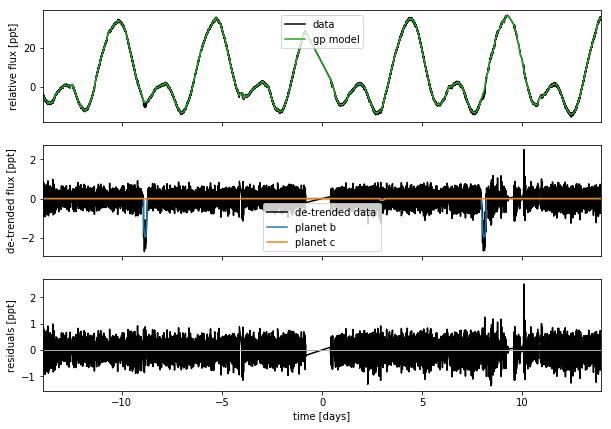

In [12]:
def plot_light_curve(model, soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = xo.utils.eval_in_model(model.pred, soln, model=model)
    gp_mod += soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    light_curves = xo.utils.eval_in_model(model.light_curves, soln, model=model)
    for i, l in enumerate(["b", "c",]):
        mod = light_curves[:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(light_curves, axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(model0, map_soln0);

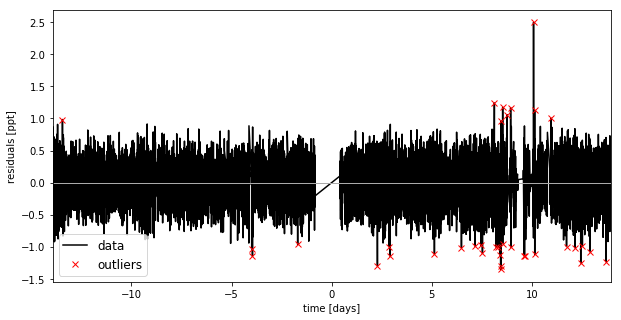

In [13]:
mod = map_soln0["pred"] + map_soln0["mean"] + map_soln0["light_curve"]
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
plt.xlim(x.min(), x.max());

/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -5,225.7, ||grad|| = 272.21: 100%|██████████| 8/8 [00:00<00:00, 69.88it/s]   
logp = -4,946.2, ||grad|| = 0.24894: 100%|██████████| 23/23 [00:00<00:00, 56.90it/s]  
logp = -4,939.2, ||grad|| = 0.22858: 100%|██████████| 25/25 [00:00<00:00, 52.22it/s]  
logp = -4,938.5, ||grad|| = 3.4533: 100%|██████████| 20/20 [00:00<00:00, 76.08it/s]  
logp = -4,938, ||grad|| = 0.022898: 100%|██████████| 29/29 [00:00<00:00, 57.10it/s]  
logp = -4,930.5, ||grad|| = 8.5561: 100%|██████████| 86/86 [00:01<00:00, 71.70it/s]   


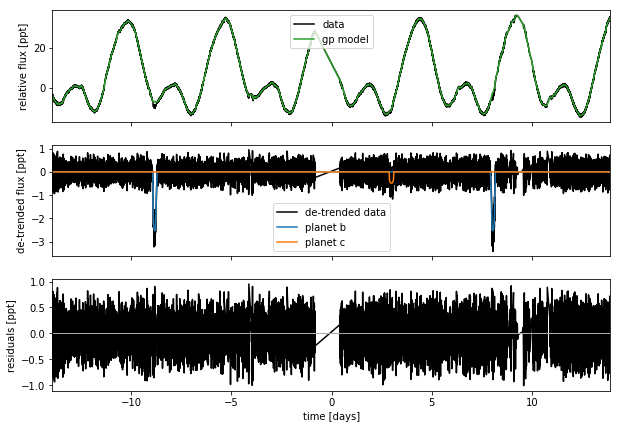

In [14]:
model, map_soln = build_model(mask, map_soln0)
fig = plot_light_curve(model, map_soln, mask)
fig.savefig('gp-map-aumic.png', dpi=200)

In [15]:
sampler = xo.PyMC3Sampler(window=200, start=200, finish=200)
with model:
    burnin = sampler.tune(tune=6000, start=map_soln, step_kwargs=dict(target_accept=0.9), )

/home/tom/anaconda3/envs/p37/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sampling 4 chains: 100%|██████████| 808/808 [17:57<00:00,  5.31s/draws]


In [16]:
start, step = sampler._get_start_and_step()
with model:
    step = pm.NUTS(potential=step.potential, target_accept=0.9)
    trace = pm.sample(draws=8000, tune=200, step=step, start=start)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [omega, ecc, b_param, logror, t0, logP, logrho_star, r_star, u_star, mix, logdeltaQ, logQ0, logperiod, logamp, logw, logS, logs2, mean]
Sampling 4 chains: 100%|██████████| 32800/32800 [17:08:13<00:00,  5.98s/draws]  
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8055761448459142, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


In [22]:
pm.summary(trace, varnames= ['b', 'logror', 't0', 'logP', 'ecc', 'omega',
           'logrho_star', 'r_star', 'u_star', 'mix', 'logdeltaQ', 'logQ0', 'logperiod', 'logamp', 'logw', 'logS',
                             'logs2', 'mean', 'r_ple', 'p_period', 'ror'], alpha=0.317)

,mean,sd,mc_error,hpd_15.85,hpd_84.15,n_eff,Rhat
b__0,0.461012,0.229280,0.002430,3.134972e-01,0.810427,8545.304493,1.000335
b__1,0.596653,0.275074,0.002686,4.313342e-01,0.973318,8269.879560,1.000414
logror__0,-3.065122,0.074523,0.001007,-3.130367e+00,-2.993794,5555.732376,1.000467
logror__1,-4.194165,1.089610,0.024145,-4.280605e+00,-3.236900,2346.467938,1.001260
t0__0,-8.840202,0.008212,0.000103,-8.850756e+00,-8.835368,6160.274358,1.000057
t0__1,2.985950,0.053725,0.000679,2.959813e+00,3.015113,6233.671758,1.000542
logP__0,2.828088,0.000826,0.000011,2.827752e+00,2.828962,6247.095705,1.000019
logP__1,3.415685,0.099369,0.000578,3.315501e+00,3.513843,28442.306082,1.000034
ecc__0,0.210153,0.165656,0.001327,7.124290e-07,0.271770,12444.873819,0.999994
ecc__1,0.254330,0.197155,0.002438,2.252424e-06,0.341287,9179.592864,1.000926


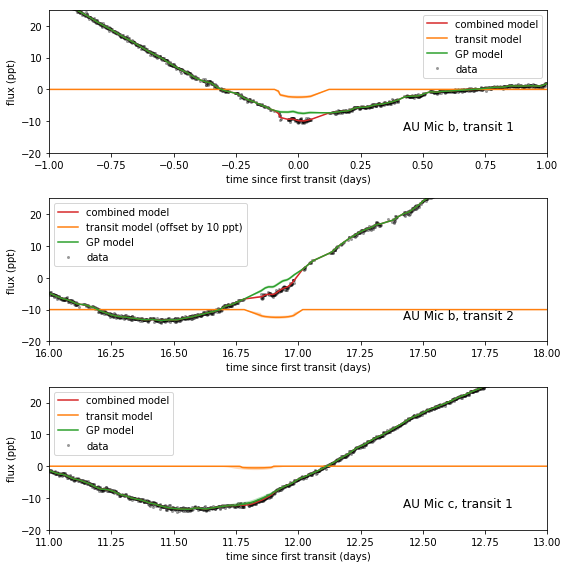

In [18]:
pred = np.percentile(trace["light_curve"] + trace["mean"][:, None] +
                     trace["pred"], [5,50,95], axis=0)
pred1 = np.percentile(trace["light_curve"], [5,50,95], axis=0)
pred2 = np.percentile(trace["pred"] + trace["mean"][:, None], [5,50,95], axis=0)

fig,  [ax1, ax2, ax3] = plt.subplots(3,1, figsize=[8, 8])
time = x[mask] - np.median(trace['t0'][:,0])

ax1.plot(time, pred[1], color='C3', label = 'combined model')
art = ax1.fill_between(time, pred[0], pred[2], color="C3", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax1.plot(time, pred1[1], color='C1', label = 'transit model')
art = ax1.fill_between(time, pred1[0], pred1[2], color="C1", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax1.plot(time, pred2[1], color='C2', label = 'GP model')
art = ax1.fill_between(time, pred2[0], pred2[2], color="C2", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax1.plot(time, y[mask], ".k", label="data",
         alpha=0.4, zorder=-1000, mec="none")

ax1.set_xlim(-1,1)
ax1.set_ylim(-20, 25)

ax1.legend()
ax1.set_xlabel("time since first transit (days)")
ax1.set_ylabel("flux (ppt)")

ax1.annotate('AU Mic b, transit 1', (0.7, 0.1), xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points",
             ha="left", va="bottom", fontsize=12)

ax2.plot(time, pred[1], color='C3', label = 'combined model')
art = ax2.fill_between(time, pred[0], pred[2], color="C3", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax2.plot(time, pred1[1] -10, color='C1', label = 'transit model (offset by 10 ppt)')
art = ax2.fill_between(time, pred1[0] -10, pred1[2]-10, color="C1", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax2.plot(time, pred2[1], color='C2', label = 'GP model')
art = ax2.fill_between(time, pred2[0], pred2[2], color="C2", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax2.plot(time, y[mask], ".k", label="data",
         alpha=0.4, zorder=-1000, mec="none")

ax2.set_xlim(16,18)
ax2.set_ylim(-20, 25)
ax2.legend()
ax2.set_xlabel("time since first transit (days)")
ax2.set_ylabel("flux (ppt)")

ax2.annotate('AU Mic b, transit 2', (0.7, 0.1), xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points",
             ha="left", va="bottom", fontsize=12)

ax3.plot(time, pred[1], color='C3', label = 'combined model')
art = ax3.fill_between(time, pred[0], pred[2], color="C3", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax3.plot(time, pred1[1], color='C1', label = 'transit model')
art = ax3.fill_between(time, pred1[0], pred1[2], color="C1", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax3.plot(time, pred2[1], color='C2', label = 'GP model')
art = ax3.fill_between(time, pred2[0], pred2[2], color="C2", alpha=0.3,
                       zorder=1000)
art.set_edgecolor("none")

ax3.plot(time, y[mask], ".k", label="data",
         alpha=0.4, zorder=-1000, mec="none")

ax3.set_xlim(11, 13)
ax3.set_ylim(-20, 25)
ax3.legend()
ax3.set_xlabel("time since first transit (days)")
ax3.set_ylabel("flux (ppt)")

ax3.annotate('AU Mic c, transit 1', (0.7, 0.1), xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points",
             ha="left", va="bottom", fontsize=12)

plt.tight_layout()
plt.savefig('transits-GP-v2.png', dpi=200)

In [19]:
# # Compute the GP prediction
# gp_mod = np.median(trace["pred"] + trace["mean"][:, None], axis=0)

# # Get the posterior median orbital parameters
# p = np.median(trace["p_period"][:,1])
# t0 = np.median(trace['t0'][:,1])

# # Plot the folded data
# fig,  [ax1, ax2] = plt.subplots(2,1, figsize=[8, 8])

# x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
# plt.plot(x_fold * 24., y[mask] - gp_mod, ".k", label="data",
#          alpha=0.5, zorder=-1000, mec="none")

# # # Overplot the phase binned light curve
# # bins = np.linspace(-10, 10, 50)
# # denom, _ = np.histogram(x_fold, bins)
# # num, _ = np.histogram(x_fold, bins, weights=y[mask])
# # denom[num == 0] = 1.0
# # plt.plot(0.5*(bins[1:] + bins[:-1]) *  24., num / denom, "o", color="C2",
# #          label="binned")

# # Plot the folded model
# inds = np.argsort(x_fold)
# inds = inds[np.abs(x_fold)[inds] < 0.3]
# pred = trace["light_curve"][:, inds]
# pred = np.percentile(pred, [16, 50, 84], axis=0)
# plt.plot(x_fold[inds] * 24., pred[1], color="C1", label="model")
# # art = plt.fill_between(x_fold[inds] * 24., pred[0], pred[2], color="C1", alpha=0.3,
# #                        zorder=1000)
# # art.set_edgecolor("none")

# # Annotate the plot with the planet's period
# txt = "period = {0:.5f} +/- {1:.5f} days".format(
#     np.mean(trace["p_period"][:,1]), np.std(trace["p_period"][:,1]))

# plt.annotate(txt, (0, 0.9), xycoords="axes fraction",
#              xytext=(5, 5), textcoords="offset points",
#              ha="left", va="bottom", fontsize=12)

# # plt.annotate('AU Mic b', (0, 1), xycoords="axes fraction",
# #              xytext=(5, 5), textcoords="offset points",
# #              ha="left", va="bottom", fontsize=12)

# plt.legend(fontsize=10, loc=4)
# plt.xlabel("time since transit [hours]")
# plt.ylabel("de-trended flux (ppt)")
# plt.xlim(-7, 7);
# plt.ylim(-2, 2);

# plt.tight_layout()
# plt.savefig('transit-plot-2.png', dpi=200)

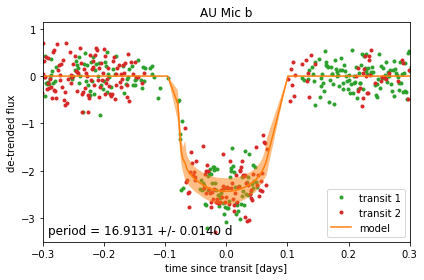

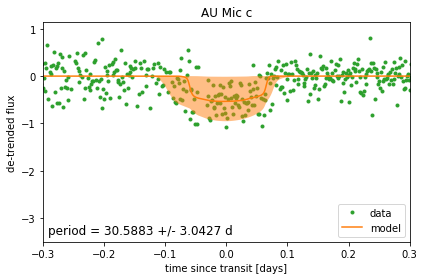

In [31]:
for n, letter in enumerate("bc"):
    plt.figure()
    
    # Compute the GP prediction
    gp_mod = np.median(trace["pred"], axis=0)
    offset = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["p_period"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
#     other = np.median(trace["light_curve"][:, :,], axis=0)

    # Plot the folded data
    x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
    mid = int(np.shape(x[mask])[0] / 2)
    x_fold0 = (x[mask][:mid] - t0 + 0.5*p) % p - 0.5*p
    x_fold1 = (x[mask][mid:] - t0 + 0.5*p) % p - 0.5*p
    if n == 0:
        plt.plot(x_fold0, y[mask][:mid] - gp_mod[:mid] - offset, ".C2", label="transit 1", zorder=-1000)
        plt.plot(x_fold1, y[mask][mid:] - gp_mod[mid:] - offset, ".C3", label="transit 2", zorder=-1000)
    elif n == 1:
        plt.plot(x_fold, y[mask] - gp_mod - offset, ".C2", label="data", zorder=-1000)
    
    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curve"][:, inds] #- offset # + trace["mean"][:, None] 
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0],
                           pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")
    
    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["p_period"][:, n]), np.std(trace["p_period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points", 
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
#     plt.ylim(-4,2)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("AU Mic {0}".format(letter));
    plt.xlim(-0.3, 0.3)
    plt.tight_layout()
    plt.savefig('transit-plot-{}.png'.format(n+1), dpi=200)

ValueError: x and y must have same first dimension, but have shapes (15878,) and (1, 15878)

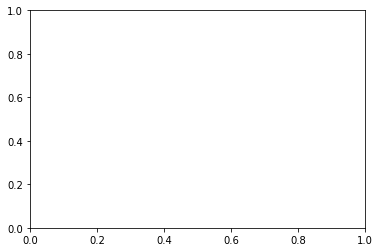

In [21]:
n = 0
resid = y[mask] - trace["pred"] - trace["mean"][:, None]
p = np.median(trace["p_period"][:, n])
t0 = np.median(trace["t0"][:, n])
x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
plt.plot(x_fold, np.percentile(resid, [16], axis=0), ".C2", label="data", zorder=-1000)
plt.plot(x_fold, np.percentile(resid, [50], axis=0), ".C2", label="data", zorder=-1000)
plt.plot(x_fold, np.percentile(resid, [84], axis=0), ".C2", label="data", zorder=-1000)

(-0.3, 0.3)

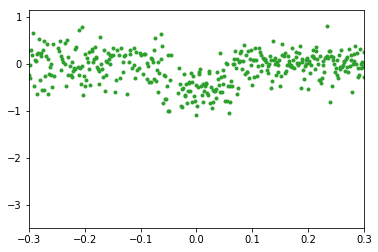

In [24]:
pred = np.percentile(resid, [16, 50, 84], axis=0)
plt.plot(x_fold, pred[1], ".C2", label="data", zorder=-1000)
plt.xlim(-0.3, 0.3)

In [25]:
map_soln0

{'mean': array(6.52882114),
 'logs2': array(-2.39280003),
 'logS': array(-2.98246078),
 'logw': array(3.37673192),
 'logamp': array(5.03765618),
 'logperiod': array(1.58292243),
 'logQ0': array(2.93485094),
 'logdeltaQ': array(9.9145813),
 'mix_interval__': array(-1.18581046),
 'u_star_quadlimbdark__': array([-0.57536414, -0.69314718]),
 'r_star': array(0.75),
 'logrho_star': array(-0.10536052),
 'logP': array([2.82825524, 3.42921204]),
 't0': array([-8.82244677,  2.9953215 ]),
 'logror_upperbound__': array([0.68895411, 1.26911893]),
 'b_param_interval__': array([-0.78097465, -0.67497811]),
 'ecc_interval__': array([-1.94591015, -1.94591015]),
 'omega_angle__': array([[0., 0.],
        [1., 1.]]),
 'period': array(4.86916485),
 'mix': array(0.23400907),
 'u_star': array([0.4, 0.2]),
 'rho_star': array(0.9),
 'logror': array([-3.19560421, -4.76168937]),
 'ror': array([0.04094178, 0.00855115]),
 'b_param': array([0.31410987, 0.33738306]),
 'b': array([0.32697008, 0.34026807]),
 'ecc': ar

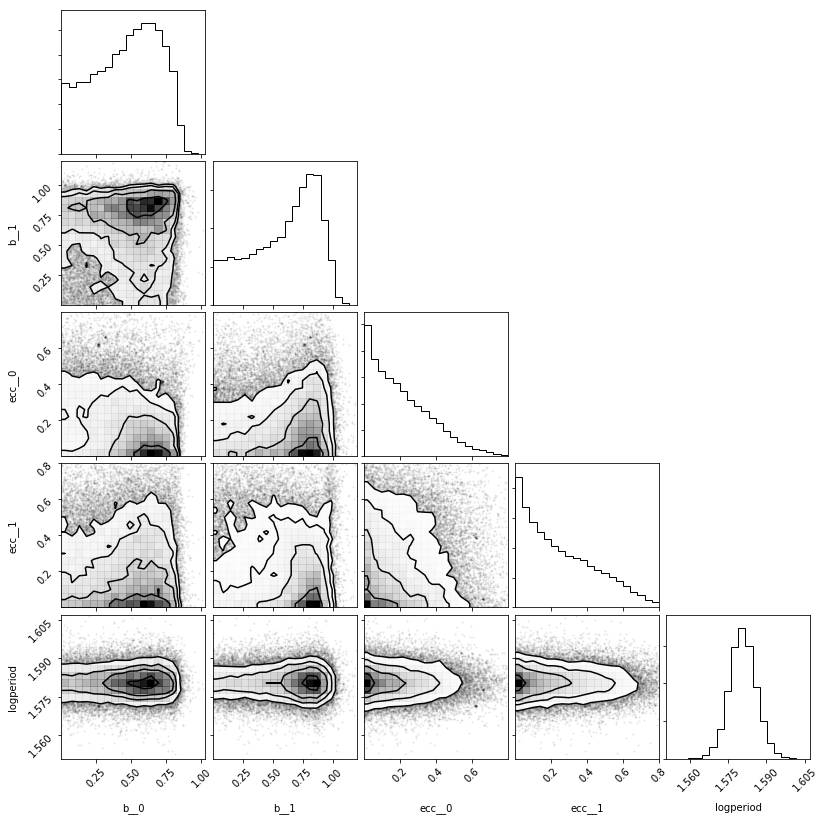

In [26]:
import corner
varnames = ["b", "ecc", 'logperiod']
samples = pm.trace_to_dataframe(trace, varnames=varnames)
corner.corner(samples);



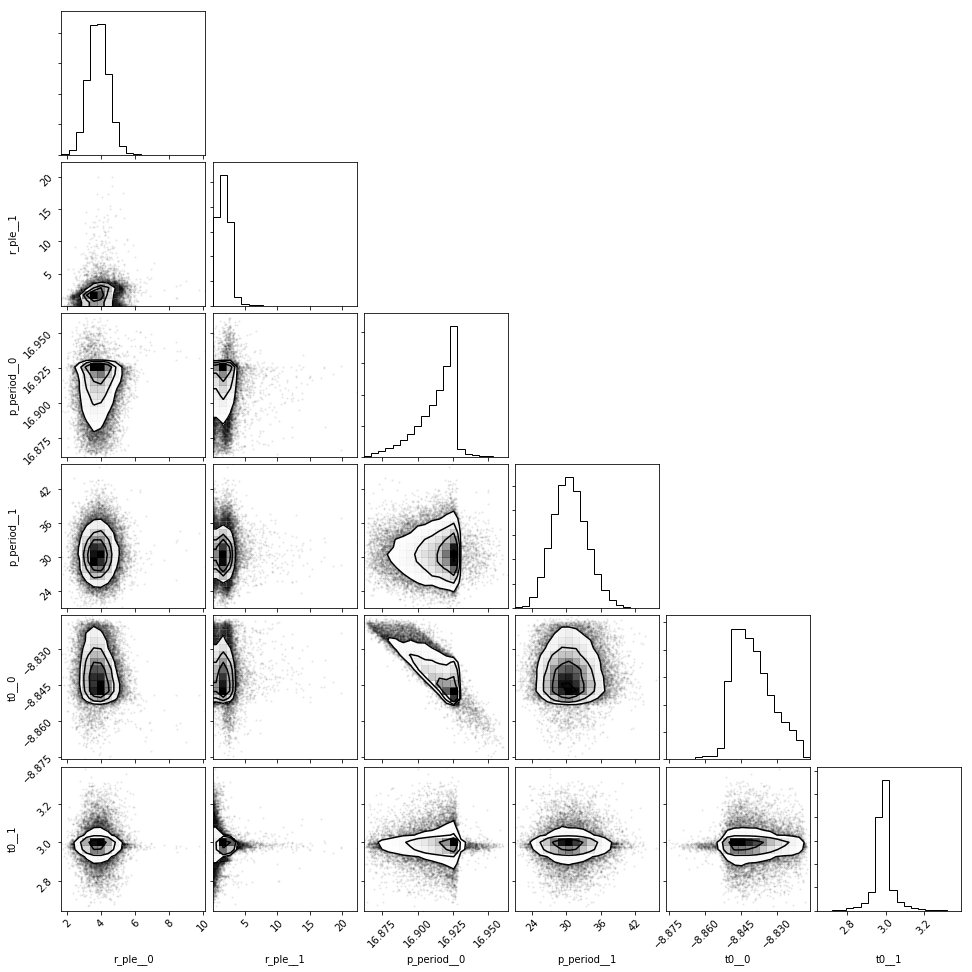

In [27]:
import corner
varnames = ["r_ple", "p_period", 't0']
samples = pm.trace_to_dataframe(trace, varnames=varnames)
corner.corner(samples);


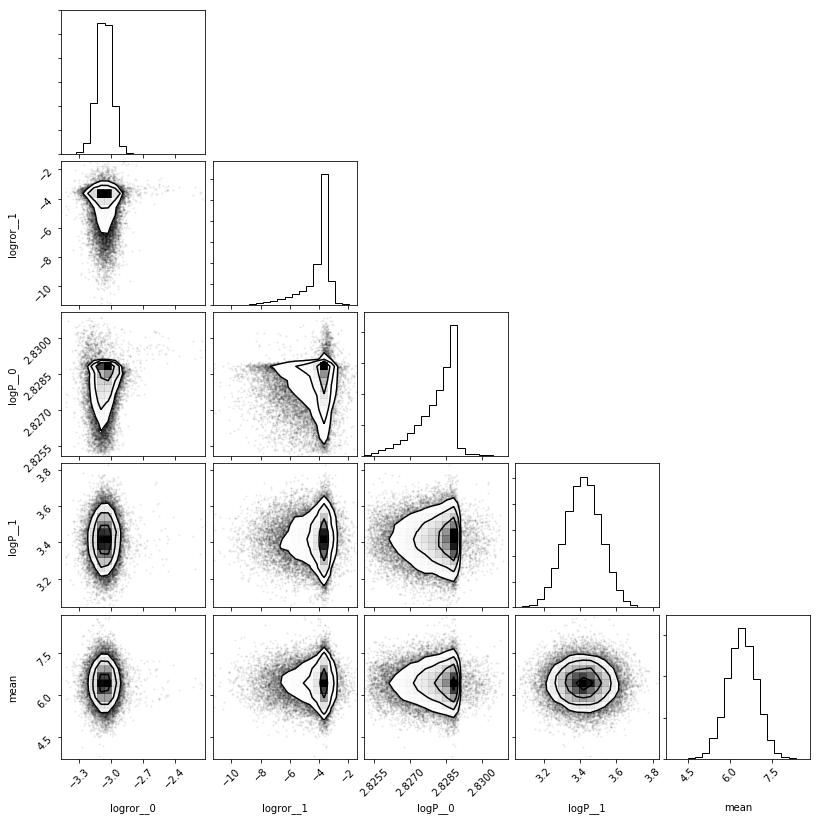

In [29]:
import corner
varnames = ["logror", "logP", 'mean']
samples = pm.trace_to_dataframe(trace, varnames=varnames)
corner.corner(samples);

In [30]:
pm.save_trace(trace)

'.pymc_1.trace'

In [36]:
del model0

In [35]:
whos

Variable             Type                  Data/Info
----------------------------------------------------
SkyCoord             ABCMeta               <class 'astropy.coordinat<...>sky_coordinate.SkyCoord'>
TessLightCurveFile   type                  <class 'lightkurve.lightc<...>file.TessLightCurveFile'>
art                  PolyCollection        <matplotlib.collections.P<...>object at 0x7f47fd3dbac8>
ax1                  AxesSubplot           AxesSubplot(0.0916667,0.726736;0.864952x0.248437)
ax2                  AxesSubplot           AxesSubplot(0.0916667,0.399653;0.864952x0.248437)
ax3                  AxesSubplot           AxesSubplot(0.0916667,0.0<...>725694;0.864952x0.248437)
build_model          function              <function build_model at 0x7f4869539158>
corner               module                <module 'corner' from '/h<...>ages/corner/__init__.py'>
fig                  Figure                Figure(576x576)
fits                 module                <module 'astropy.io.fits'<.